In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Walks for Finance Part 1: Introduction to Discrete Time Quantum Walks 
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$


---
## Overview
This notebook is part of a series designed to build your skills with simple examples, providing the foundation for exploring more advanced content.
Here, we'll focus on the discrete-time quantum walk (DTQW).  You will learn about quantum walks by comparing them to classical random walks. By the end of the tutorial, you will have coded a variational discrete time quantum walk in CUDA-Q. This experience will prepare you for the next notebook, where we'll tackle a finance problem by exploring advanced walking protocols and parameter optimization.

**What you'll do:**
* Review CUDA-Q programming syntax
* Compare classical random walks with a discrete time quantum walk
* Develop and implement a kernel with custom gates for a discrete time quantum walk along a line segment

**CUDA-Q syntax you'll use:**
* quantum kernel function decoration: `@cudaq.kernel`
* qubit initialization: `cudaq.qvector` and `cudaq.qubit`
* quantum gates: `x`, `h`, `t`, _`.ctrl`, `cudaq.register_operation`
* execute a kernel: `sample`, `get_state`, _`.amplitude`
* visualize circuit structure of a kernel: `cudaq.draw`

**Pre-requisites:** Learners should have familiarity with Jupyter notebooks and programming in Python and CUDA-Q. It is assumed the reader has some familiarity already with quantum computation and is comfortable with braket notation and the concepts of qubits, quantum circuits, measurement, and circuit sampling. The CUDA-Q Academic course entitled "[Quick Start to Quantum Computing with CUDA-Q](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum)" provides a walkthrough of this prerequisite knowledge if the reader is new to quantum computing and CUDA-Q or needs refreshing.


First let's install the necessary packages.

In [ ]:
## Instructions for Google Colab. You can ignore this cell if you have cuda-q set up and have 
# all the dependent files on your system
# Uncomment the lines below and execute the cell to install cuda-q

#!pip install cudaq

#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/2025-GTC-DC.zip
#!unzip -q 2025-GTC-DC.zip
#!mv cuda-q-academic-2025-GTC-DC/workshops/2025-GTC-DC/images ./images

In [8]:
import cudaq
import numpy as np
import matplotlib.pyplot as plt

---
## Motivation

This section will prepare us for the `02_learnable_quantum_walk.ipynb` notebook, where we address the following problem:

> **Encoding Probability Distributions Problem**:  Given a discrete probability distribution $\mathcal{P}$, generate a quantum kernel (i.e., a sequence of quantum gates) that transforms an initial state into a final state whose measurement outcomes match the target distribution $\mathcal{P}$.

One approach to tackle this problem is through random walks by using a variational algorithm to search for the random walk that will generate a targeted distribution, as depicted in the animation below.

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/refs/heads/main/images/quantum_walk_target.gif" width="600">

Before we tackle that problem, we need to define quantum random walks.  Let's first visualize a classical random walk along a number line generating a binomial distribution. You can imagine a walker moving left or right depending on the result of a coin flip.  



Let's see this in action with [this random walk widget](https://nvidia.github.io/cuda-q-academic/quantum-applications-to-finance/images/ss-random-walk.html). The green dot represents the walker whose movements are dictated by flips of a coin whose fairness is controlled by the probability slider. The ending position from each run of the experiment is recorded in the histogram.  
> **⌨️ Exercise 1:**
> Experiment by changing the number of total steps, the probabilities, and the rules for taking a step in [the widget](https://nvidia.github.io/cuda-q-academic/quantum-applications-to-finance/images/ss-random-walk.html). What patterns do you notice?




Unlike classical random walks, where probabilities dictate movement, quantum walks rely on amplitudes. Interference between paths leads to a faster spread over the position space, making quantum walks useful for generating more complex probability distributions.  

We start this section by defining classical random walks and discrete-time quantum walks (DTQW). In the following section, we use CUDA-Q to encode an example of a DTQW into a CUDA-Q kernel.

## Comparing Classical Random Walks with Discrete Time Quantum Walks

Let's consider a discrete walk taking place on a line. In this scenario, we envision a walker progressing along the
x-axis in discrete increments, with the movement governed by predefined rules based on coin flips. A classical random walk can be viewed as a decision tree, as in the diagram below. Here, a walker begins in the center of the line. After a coin flip, the walker moves to the left or right depending on the outcome of the coin flip (e.g., flipping heads will send the walker one step to the left, while flipping tails will send the walker one step to the right). After $n$ coin flips, we record the position of the walker. This experiment is repeated multiple times to generate a histogram of the walker's final position.

<img src="https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/images/classical-walk.png?raw=1" width="600">

A quantum walk fundamentally differs from its classical counterpart by incorporating two key principles of quantum mechanics: **superposition** and **interference**. Instead of a classical coin that can only be heads or tails, we use a **qubit** that can exist in a superposition of both states simultaneously. This means the walker, whose movement depends on the coin, can also move left and right at the same time, exploring multiple paths at once. As the walk progresses, these different paths can interfere with each other, either constructively (increasing the probability of finding the walker at a certain position) or destructively (decreasing it). This interference leads to drastically different probability distributions compared to the classical random walk, which results in a binomial distribution.

The diagram below illustrates a 2-step quantum walk. We'll explain the notation in detail shortly, but for now, focus on the main result: the final distribution of the walker's possible positions is already strikingly different from the classical case.


<img src="https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/images/dtqw-superposition-coin.png?raw=1" width="600">

### The Quantum Coin: Qubits

The heart of the quantum walk is the "quantum coin." Unlike a classical coin which lands on either heads or tails, a quantum coin can be in a superposition of both. This is made possible by using a qubit.

A classical bit is the basic unit of information, having a definite state of either 0 or 1. A **qubit** (quantum bit) is the quantum analog. It can be in the state $\ket{0}$, the state $\ket{1}$, or a **superposition** of both.

Mathematically, we represent the basis states, known as the **computational basis**, as column vectors:

$$\ket{0} = \begin{pmatrix} 1 \\ 0 \end{pmatrix} \quad \text{and} \quad \ket{1} = \begin{pmatrix} 0 \\ 1 \end{pmatrix}$$

A quantum state, which we'll refer to as $\ket{\psi_C}$ to represent the state of the coin, is a linear combination of these basis states:

$$\ket{\psi_C} = \alpha\ket{0} + \beta\ket{1} = \alpha\begin{pmatrix} 1 \\ 0 \end{pmatrix} + \beta\begin{pmatrix} 0 \\ 1 \end{pmatrix} = \begin{pmatrix} \alpha \\ \beta \end{pmatrix}$$

Here, $\alpha$ and $\beta$ are complex numbers called **probability amplitudes**. When we measure the qubit, the probability of it collapsing to state $\ket{0}$ is $|\alpha|^2$, and the probability of it collapsing to state $\ket{1}$ is $|\beta|^2$. The sum of these probabilities must be 1, so $|\alpha|^2 + |\beta|^2 = 1$. For our walk, we can associate $\ket{0}$ with "heads" and $\ket{1}$ with "tails."

A convenient way to visualize a single qubit's state is with the **Bloch Sphere**. On this sphere, the North Pole represents the state $\ket{0}$ and the South Pole represents the state $\ket{1}$. Any other point on the surface of the sphere represents a unique superposition of $\ket{0}$ and $\ket{1}$.

> **⌨️ Exercise 2: Visualize a quantum coin on the Bloch Sphere**
>
> Use the [interactive Bloch sphere widget](https://nvidia.github.io/cuda-q-academic/quantum-applications-to-finance/images/quantum_coin_widget.html) to get a feel for how the amplitudes $\alpha$ and $\beta$ define a qubit's state. As you adjust the sliders, notice how the state vector (the green arrow) moves and how the measurement probabilities change.
>
> Try to find the following states:
>
> 1.  **The Basis States:**
>    * First, create the state $\ket{0}$. What are the values of $\alpha$ and $\beta$? Where is the vector pointing?
>    * Next, create the state $\ket{1}$. What do $\alpha$ and $\beta$ become?
>
> 2.  **The Fair Quantum Coin:**
>    * Adjust the sliders to find a state where there's a **50%** chance of measuring $\ket{0}$ and a **50%** chance of measuring $\ket{1}$. This is called an **equal superposition**.
>    * Where on the sphere does this state live?
>    * What are the (real, positive) values for $\alpha$ and $\beta$ that give you these probabilities? (Hint: $P(\ket{0})=|\alpha|^2$)
>
> 3.  **The Biased Coin:**
>    * Now, try to create a state that has a **75%** chance of being measured as $\ket{0}$ and a **25%** chance of being measured as $\ket{1}$.
>    * Roughly, where is this state located on the sphere compared to $\ket{0}$ and the "fair coin" state?
>
> 4.  **Challenge Question:**
>    * Go back to the 50/50 "fair coin" state. Now, try to find *another* point on the sphere that also gives 50/50 measurement probabilities. What does this tell you about how two different quantum states can still have the same measurement outcomes?

<img src="images/mentimeter_qr_code.png" alt="QR Code" width="150" height="150">

For Exercise 2, the QR above can be used to access the interactive poll during the tutorial. The link will not be active after the workshop.


### Flipping the Coin: Applying a Quantum Gate to a Single-Qubit State
In a classical walk, we flip the coin. In a quantum walk, we apply a **quantum gate** to the coin qubit. Quantum gates applied to a single qubit can be visualized as a rotation on the Bloch sphere and corresponds to multiplication by a unitary matrix.

#### The Quantum Flip: The Hadamard Gate
  

Let's examine a standard choice for the "coin flip" operation: the **Hadamard gate (H)**, represented by the matrix
$$H = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}.$$

The Hadamard gate takes a computational basis state ($\ket{0}$ or $\ket{1}$) and puts it into an equal superposition of both:

* $H\ket{0} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix} = \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})$
* $H\ket{1} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \begin{pmatrix} 0 \\ 1 \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ -1 \end{pmatrix} = \frac{1}{\sqrt{2}}(\ket{0} - \ket{1})$

If we start our coin in the state $\ket{0}$ (heads) and apply the Hadamard gate, its new state is $\frac{1}{\sqrt{2}}(\ket{0} + \ket{1})$. Now, the coin is in a perfect superposition of heads and tails. If we were to measure it, we'd have a 50% chance of getting $\ket{0}$ and a 50% chance of getting $\ket{1}$. On the Bloch sphere, the Hadamard gate performs a rotation that takes the state $\ket{0}$ from the North Pole to the positive $x$-axis.  The state $\frac{1}{\sqrt{2}}(\ket{0} + \ket{1})$ is commonly denoted as $\ket{+}$.  Similarly the Hadamard gate takes the state $\ket{1}$ to the state  $\frac{1}{\sqrt{2}}(\ket{0} - \ket{1})$, which is denoted as $\ket{-}$.


#### The Bit Flip: Pauli-X Gate (or NOT Gate)

Another fundamental quantum gate is the **Pauli-X gate**, often called the **X gate**. It's the quantum equivalent of a classical **NOT gate**, performing a "bit-flip" operation.

The $X$ gate transforms the state $\ket{0}$ into $\ket{1}$ and the state $\ket{1}$ into $\ket{0}$. The unitary matrix representing the X gate is:

$$X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$$

Applying this matrix to our basis states explicitly shows the flip:

* $X\ket{0} = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \begin{pmatrix} 0 \\ 1 \end{pmatrix} = \ket{1}$
* $X\ket{1} = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 0 \\ 1 \end{pmatrix} = \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \ket{0}$

On the Bloch sphere, the $X$ gate corresponds to a 180-degree rotation around the $x$-axis. This rotation is what visually moves the state vector from the North Pole ($\ket{0}$) to the South Pole ($\ket{1}$), and vice-versa.  

Our "quantum coin" isn't limited to just the Hadamard or bit flip. In reality, any rotation on the Bloch sphere corresponds to a valid single-qubit gate, giving us an infinite set of tools for our coin-flip operation. In fact, we're not limited to constant coin operators, and could consider a coin operator that depends on parameters such as the Grover operator used for searching a graph for marked vertices ([Li and Sun](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.6.033042), or for an exposition [Wong](https://arxiv.org/pdf/2011.14533)). Moreover, the coin operator might depend on parameters that change from one step to the next and can be learnable, as we'll see in the next tutorial.

> **⌨️ Exercise 3:**
> Click [this interactive widget](https://nvidia.github.io/cuda-q-academic/quantum-applications-to-finance/images/gate-widget.html) to learn about several other standard gates. 
>As you apply each gate, you'll see a diagram appear showing boxes on a horizontal line. This is a preview of a quantum circuit diagram, a standard way to visualize quantum operations that we will cover in detail later.
>
> For this exercise, focus your attention on the Bloch sphere to see how each gate rotates the state vector. Think about the following questions:
>  * What do the S and T gates do? Do they change the probability of measuring 0 or 1, or do they only change the phase?
>  * Apply the T gate. Now apply it again and again. How many times must you apply the T gate to get the same result as a single Z gate?


Now that you've seen how quantum gates manipulate a qubit's state, let's learn how to combine them into a sequence of instructions, or a **quantum circuit**. To do this, we need to introduce a few key concepts from CUDA-Q.

#### Quantum Kernels

In CUDA-Q, quantum algorithms are written inside **quantum kernels**. Think of a kernel as a function containing instructions for a quantum processor. A key feature is that kernels can blend quantum gates with classical control flow. Because of this, any standard quantum circuit can be expressed as a kernel, but a kernel's ability to be dynamic means it goes beyond what a static circuit can represent.

Let's use CUDA-Q to define a quantum kernel that generates the minus state ($\ket{-}$). The syntax is simple: we write a Python function for our quantum instructions and then identify it as a kernel by adding `@cudaq.kernel` on the line above. The kernel's instructions are to initialize a qubit to $\ket{1}$ and then apply a Hadamard gate.


In [9]:
# Kernel for the minus state

@cudaq.kernel
def minus_kernel():
    # Allocate a qubit, which by default is in the |0> state
    qvector = cudaq.qvector(1)
    # qvector = cudaq.qubit()

    # Change the state of the qubit from |0> to |1>
    x(qvector)

    # Apply the Hadamard gate
    h(qvector)

# Draw the circuit to check our work
print(cudaq.draw(minus_kernel))

     ╭───╮╭───╮
q0 : ┤ x ├┤ h ├
     ╰───╯╰───╯



Executing the cell above only defines the kernel and prints out the circuit diagram; the actual quantum computation has not yet been carried out.  For that we have a few options.

#### Sampling vs. State Vector

There are two primary ways to get results from our kernel:

1.  **Sampling**: When a quantum computer runs, we can't see the superposition directly. The act of measurement collapses the state into a definite 0 or 1. **Sampling** involves running the kernel many times (e.g., 1000 "shots") and counting the outcomes to build a probability distribution. This mimics how real quantum hardware operates.
2.  **Getting the State**: When using a simulator, we have a special ability: we can peek "under the hood" and see the qubit's exact quantum state before measurement. The `cudaq.get_state()` command allows us to retrieve the complete state vector—the complex amplitudes ($\alpha$ and $\beta$) that define the superposition.

Here we demonstrate how to sample and get the state of a the `minus_kernel` that we previously defined.


In [10]:
# Sampling the minus kernel
shots = 1000
results = cudaq.sample(minus_kernel, shots_count=shots)
print("Results from sampling {} times: {}".format(shots, results))

# Often it will be useful to identify the most probable outcome
# and the probability of this outcome
most_probable_result = results.most_probable()
probability = results.probability(most_probable_result)
print("Most probable result: " + most_probable_result)
print("Measured with probability " + str(probability), end='\n\n')

Results from sampling 1000 times: { 0:510 1:490 }

Most probable result: 0
Measured with probability 0.51



In [11]:
# Getting the state of the minus kernel

# Compute the state of the system prior to measurement the output
minus_state = cudaq.get_state(minus_kernel)

# Often it will be useful to identify the amplitudes of specific computational basis states
# In this example, we only have two computational basis states |0> and |1>
minus_amplitudes = minus_state.amplitudes([[0], [1]])

# Print the state in a nice format
precision = 4
print('Minus statevector array of coefficients:', np.round(np.array(minus_state), precision))
print('Minus statevector: {} |0> + {} |1>'.format(np.round(minus_amplitudes[0],precision), np.round(minus_amplitudes[1],precision)))



Minus statevector array of coefficients: [ 0.7071+0.j -0.7071+0.j]
Minus statevector: (0.7071+0j) |0> + (-0.7071+0j) |1>


### Defining the Walker: Quantum Register
Now that we have our quantum coin, we need to define how the walker moves based on the coin's state. The walker's position is also a quantum state, stored in a set of qubits called a **quantum register**.


#### The Line that the Walker Traverses
 For our example, we consider a line that contains $16$ positions: $0,1,\cdots,15$ encoded with the computational basis states on $4$ qubits: $\ket{\bf{0}} = \ket{0000}, \ket{\bf{1}} = \ket{0001}, \ket{\bf{2}} = \ket{0010}, \cdots, \ket{\bf{15}} = \ket{1111}$. In other words, the computational basis state $\ket{\bf{i}}$ represents the $i^{th}$ location on the line.


### The Walker's Position State
The walker's position after $t$ time steps is given by a linear combination of the computational basis states $$\ket{\psi_W} = \sum_{i}\alpha_i(t)\ket{\bf{i}},$$ for some $\alpha_i(t)\in\mathbb{C}$ satisfying $\sum_{i}|\alpha_i(t)|^2 = 1$. For instance, if the walker began the experiment at position $0$, then the state of the walker at time $0$ would be $\ket{\psi_W(0)}=\ket{0000}$.  

More interestingly, the walker might begin the experiment in a superposition of two or more positions, as depicted in the figure below. In this case, the walker's initial state is $\ket{\psi_W(0)}=\frac{1}{\sqrt{2}}\ket{0010}+\frac{1}{\sqrt{2}}\ket{0011}$.

<img src="https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/images/dtqw-superposition-walker.png?raw=1" width="600">

> **🔧 Exercise 4:** Now, let's code the quantum walk drawn above up to the point where the coin is first flipped.  We have the pieces for the coin, so we need to define the walker. To do this, we'll show how kernels can call other kernels by defining one for the walker's initialization and a separate, main kernel that uses it to set up the full circuit. We've left an exercise for you to edit the kernel with the appropriate gate operation to place the coin in the $\ket{+}$ state.

In [ ]:
# EXERCISE 4 SOLUTION

# Define a kernel that prepares the walker qubits in an
# equal superposition of the states |2> = |0010> and |3> = |0011>.
@cudaq.kernel
def initial_position(qubits : cudaq.qvector):
    """ Apply gates to the qubits to prepare the 1/sqrt(2)(|0010> + |0011>) state.
    Parameters
        qubits: cudaq.qvector in the |0000> state
    """
    x(qubits[2])
    h(qubits[3])


@cudaq.kernel
def circuit_for_walk():
    """ Kernel to initialize the state of the walker
    """
    # Initialize the qubits for the walker
    walker_qubits = cudaq.qvector(4)

    # Apply the initial_position kernel to the walker qubits
    # to move from the state |0000> to their initial position
    initial_position(walker_qubits)

    # Initialize the qubits for the coin
    coin_qubit = cudaq.qubit()
    # Place the coin in the plus state
    # Edit the code below this line



    # Edit the code above this line
    
    # Flipping the coin and taking the first step will be completed in the
    # next section of the notebook




### Moving the Walker: Controlled Operations
To connect the coin's state to the walker's movement, we use a **controlled gate**. A controlled gate is an operation that acts on one set of qubits (the *target*, our walker) only if another qubit (the *control*, our coin) is in a specific state.

The operation that moves the walker in a discrete time quantum walk works as follows:
* **If the coin qubit is in state $\ket{1}$ (tails),** apply an operator (INC) that shifts the walker one step to the right.
* **If the coin qubit is in state $\ket{0}$ (heads),** apply an operator (DEC) that shifts the walker one step to the left.


The diagram below illustrates the quantum circuit for a single step of the walk. Notice the control symbols on the coin's wire: the filled-in circle (⚫) is standard notation for a control on the $\ket{1}$ state (triggering the INC operation), and the open circle  (⚪) is for a control on the $\ket{0}$ state (triggering the DEC operation).

<img src="https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/images/dtqw-one-step-diagram.png?raw=1" width="600">

Because our quantum coin can be in a superposition like $\frac{1}{\sqrt{2}}(\ket{0} + \ket{1})$, this controlled operation causes the walker to *simultaneously* move left and right. The walker's position evolves into a superposition of being one step to the left and one step to the right of its previous position(s). This is the source of the quantum walk's power to explore many paths at once.



#### Walking the Line

The next step (no pun intended) is to define incrementer (`INC`) and decrementer (`DEC`) operations, which will change the state of the walker with shifts to the left and right on the number line, respectively.  We'll use these operations to build up the controlled shift operators which depend on the state of the coin.  First, let's define `INC` so that when applied to a basis state $\ket{x}$, the result is $\ket{(x+1)_{\mod{16}}}$ for $x\in \{0,\cdots 15\}$.  The unitary matrix below carries out this transformation:

\[ \begin{pmatrix} 0 & 0 & 0 & 0 & \cdots  &1\\
                        1 & 0 & 0 & 0 & \cdots &0 \\
                        0 & 1 & 0 & 0 & \cdots &0\\
                        0 & 0 & 1 & 0 & \cdots &0\\
                        \vdots & \vdots & \vdots & \vdots & \ddots &\vdots \end{pmatrix} \]

Using the `cudaq.register_operation` we can create a custom gate for this unitary matrix. The code block defines a `cudaq.kernel` to carry out the custom INC gate, and conducts a test to verify that the operation acts as expected on the zero state.  


In [13]:
# Define a custom operation on 4 qubits for the INC unitary matrix that
# maps |x> to |x+1> mod 16 and verify that it works as expected for |0000>

num_qubits = 4
size = 2**num_qubits

# Define the incrementer matrix
def incrementer(num_qubits):
    size = 2**num_qubits
    inc_matrix = np.zeros((size, size))
    for i in range(size):
        inc_matrix[i, (i - 1) % size] = 1
    return inc_matrix
print(incrementer(num_qubits))

# Create a custom register operation for the incrementer
cudaq.register_operation("INC", incrementer(num_qubits))

@cudaq.kernel
def check_incrementer_kernel(input_list : list[int]):
    qubits = cudaq.qvector(4)
    # Initialize state |input_list>
    for i in range(4):
        if input_list[i] == 1:
          x(qubits[i])
    INC(qubits[0], qubits[1], qubits[2], qubits[3])

# Check that the INC register shifts basis states up by one
for i in range(size):
    # Convert the integer `i` to its binary representation (big-endian)
    binary_str = format(i, f'0{num_qubits}b')
    input_list = [int(bit) for bit in binary_str]
    result = cudaq.sample(check_incrementer_kernel,input_list, shots_count=1000).most_probable()
    print('Incrementer kernel |{}> -> |{}>'.format(binary_str, result))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Incrementer kernel |0000> -> |0001>
Incrementer kernel |0001> -> |0010>
Incrementer kernel |0010> -> |0011>
Incrementer kernel |0011> -> |0100>
Incrementer kernel |0100> -> |0101>
Inc

> **🔧 Exercise 5** Using the fact that `DEC` is the inverse of `INC`, create a kernel for a custom `DEC` operation.

In [ ]:
# EXERCISE 5 SOLUTION

# Define a kernel on 4 qubits for the DEC operation that
# maps |x> to |x-1> mod 16 and verify that it works as expected for |0001>

# Define the decrementer matrix

def decrementer(num_qubits):
    size = 2**num_qubits
    dec_matrix = np.zeros((size, size))
    for i in range(size):
        dec_matrix[i, (i + 1) % size] = 1
    return dec_matrix


# EDIT THE CODE BELOW THIS LINE

# Create a custom register operation for the decrementer called DEC
cudaq.register_operation("DEC", decrementer(num_qubits))

# EDIT THE CODE ABOVE THIS LINE

# Create a kernel that applies the DEC to the 4-qubit state |input_list>
@cudaq.kernel
def check_decrementer_kernel(input_list: list[int]):
    qubits = cudaq.qvector(4)
    # Initialize the qubits to |input_list>
    for i in range(4):
        if input_list[i] == 1:
          x(qubits[i])
    # Apply the decrementer operation
    DEC(qubits[0], qubits[1], qubits[2], qubits[3])

# Check that the DEC register shifts basis states up by one
for i in range(size):
    # Convert the integer `i` to its binary representation (big-endian)
    binary_str = format(i, f'0{num_qubits}b')
    input_list = [int(bit) for bit in binary_str]
    result = cudaq.sample(check_decrementer_kernel,input_list,shots_count=1000).most_probable()
    print('Incrementer kernel |{}> -> |{}>'.format(binary_str, result))

Incrementer kernel |0000> -> |1111>
Incrementer kernel |0001> -> |0000>
Incrementer kernel |0010> -> |0001>
Incrementer kernel |0011> -> |0010>
Incrementer kernel |0100> -> |0011>
Incrementer kernel |0101> -> |0100>
Incrementer kernel |0110> -> |0101>
Incrementer kernel |0111> -> |0110>
Incrementer kernel |1000> -> |0111>
Incrementer kernel |1001> -> |1000>
Incrementer kernel |1010> -> |1001>
Incrementer kernel |1011> -> |1010>
Incrementer kernel |1100> -> |1011>
Incrementer kernel |1101> -> |1100>
Incrementer kernel |1110> -> |1101>
Incrementer kernel |1111> -> |1110>


#### Changing the State of the Walker Based on Coin Flips:

Now, let's put it all together to program one step of the DTQW, using the initial state $\ket{\psi_W(0)} = \frac{1}{\sqrt{2}}(\ket{0010}+\ket{0011})$.

The INC operation below is correctly controlled by the $\ket{1}$ state of the coin using the `ctrl` modifier.

> **🔧 Exercise 6** How would you modify the kernel to also include the DEC operation, ensuring it is only triggered when the coin is in the $\ket{0}$ state?
>
> Think about the gates you've learned that can manipulate a qubit's state. And remember, the coin's state is only used to control the walker's movement; its own state shouldn't be permanently altered by the process. How do you ensure the coin is returned to its original state after the DEC operation is applied?

{ 0001:500 0010:500 }



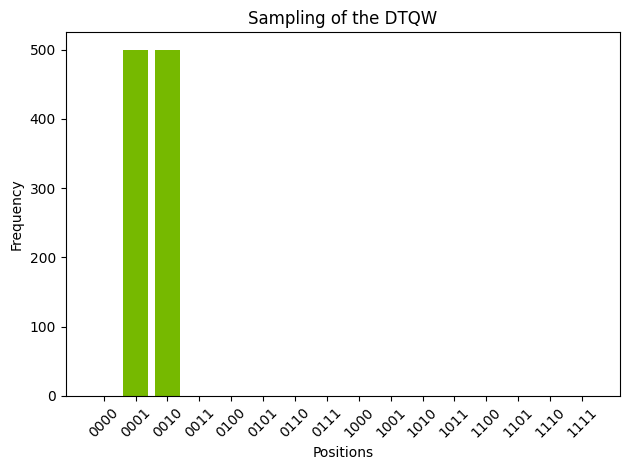

In [15]:
# EXERCISE 6 SOLUTION
# Complete the step operation
# Edit the code to apply the DEC operation to the walker qubits
# when the coin qubit is in the |0> state

# Set the number of qubits
num_qubits = 4

@cudaq.kernel
def DTQW_one_step(num_qubits: int):
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qubit()

    # Initial walker state 1/(sqrt{2}) ( |2>+|3>)
    initial_position(walker_qubits)

    # Initial coin state
    h(coin_qubit) #CHANGE_ME

    # One quantum walk step
    # Coin operation
    h(coin_qubit) #CHANGE_ME

    # Walker's position change

    ## Shifting right

    ## Shift right when the coin is |1> and the walker is not in the |1111> state
    INC.ctrl(coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3])

    ## Shifting left

    ## Shift left when the coin is |0>
    ## EDIT CODE BELOW THIS LINE
    x(coin_qubit)
    DEC.ctrl(coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3])
    x(coin_qubit)

    ## EDIT CODE ABOVE THIS LINE

    # Measure the state of the walker qubits
    mz(walker_qubits)

# Visualize the kernel for the quantum walk
#print(cudaq.draw(DTQW_one_step, num_qubits))

# Sample the kernel for the quantum walk
result = cudaq.sample(DTQW_one_step, num_qubits, shots_count=1000)
print(result)

# Define a function to draw the histogram of the results 

def plot_results(result, num_qubits):
    # Define a dictionary of results 

    # Initialize the dictionary with all possible bit strings of length 4 for the x axis
    result_dictionary = {}

    # Generate all possible bit strings of length num_qubits
    for i in range(2**num_qubits):
        bitstr = bin(i)[2:].zfill(num_qubits)
        result_dictionary[bitstr] = 0

    # Update the results dictionary of results from the circuit sampling
    for k,v in result.items():
        result_dictionary[k] = v

    # Convert the dictionary to lists for x and y values
    x = list(result_dictionary.keys())

    y = list(result_dictionary.values())

    # Create the histogram
    plt.bar(x, y, color='#76B900')

    # Add title and labels
    plt.title("Sampling of the DTQW")
    plt.xlabel("Positions")
    plt.ylabel("Frequency")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_results(result, num_qubits)

> **Final Exercise:** Exploring the Discrete Time Quantum Walk
>
> Now it's time to experiment. Your first task is to generalize the provided code to make it more powerful.
>
> 1. **Enable Multi-Step Walks**
> Modify the main kernel so that it can execute the quantum walk for an arbitrary number of steps, not just one. This will allow you to observe how the walker's probability distribution evolves over time.
>
> 🔧 Once your code is upgraded, use it to investigate the following core concepts.
>
> 2. **Classical vs. Quantum Behavior**
> Run a multi-step walk under two different conditions with a bit flip coin:
>
> * Condition A: Start with a "classical" coin (a definite state like ∣0⟩) and a walker in a definite state (e.g., $\ket{0101}$).
>
> * Condition B: Start with a "quantum" coin (a superposition state like ∣+⟩)  and a walker in a definite state (e.g., $\ket{0101}$).
>
> *Question:* Compare the final probability distributions from both conditions. How does the presence of superposition in the coin fundamentally change the walker's final state?
>
> 3. **The Signature of Interference**
>Look closely at the distribution from your quantum walk (Condition B). You'll notice the most probable locations are at the edges, while the starting position is now one of the least probable. This is a direct result of quantum interference.
>
> *Question:* Why do you think the different quantum paths leading to the center cancel each other out (destructive interference), while the paths leading to the edges reinforce each other (constructive interference)?
>
> 4. **Breaking the Symmetry**
> The Hadamard gate acts as a "fair" coin, leading to a symmetric distribution.
>
> *Challenge:* Can you design a different coin-flip operator to create an asymmetric walk? Experiment with other quantum gates to see if you can make the walker consistently prefer moving in one direction. What kind of operation is needed to break the walk's symmetry?

In the next notebook, we'll extend this idea allowing for parameterized coinflip operations, and introduce the idea of a split step.  These will allow us to generate more interesting probability distributions than what we can do with the DTQW, which may better model financial data.  

### Avoiding Walking in Circles (optional)

It is important to note that, as currently outlined above, we defined a quantum walk that will allow a walker to move between positions $\ket{0}=\ket{0000}$ and $\ket{15}=\ket{1111}$ in one step.  This behavior might not be desired, for instance, in a financial application where the positions of the walker represent stock prices and movement is related to positive or negative investor sentiment.

To prevent one-step transitions between $\ket{0}$ and $\ket{1}$ , we use an auxiliary qubit (`endpoint_qubit`), Toffoli gates, CNOT gates, and a mid-circuit `reset` to ensure a coin in the state $\ket{1}$ does not trigger a shift right (`INC`) when the walker is at $\ket{1111}$, and a coin in the state $\ket{0}$ does not trigger a shift left (`DEC`) when the walker is in the state $\ket{0000}$. This process is depicted below for one step of the DTQW:

<img src="https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/images/DTQW_endpoint.png?raw=1" width="600">

The corresponding functions to prevent one-step transitions between $\ket{0000}$ and $\ket{1111}$ and the kernel for this discrete time quantum walk are defined below.

In [16]:
# Define kernels to prevent transitions between |0000> and |1111>

# Kernel to change a coin from 1 to 0 if the walker is in the state |1111>
@cudaq.kernel
def no_INC_at_right_endpoint(walker_qubits : cudaq.qvector, coin_qubit : cudaq.qubit, right_endpoint: cudaq.qubit):

    # Test if the coin is in |1> and the walker state is |1111>,  if so, change the end_point qubit to 1
    x.ctrl([coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3]], right_endpoint)

    # Flip the state of the coin if the endpoint is triggered
    x.ctrl(right_endpoint, coin_qubit)


# Kernel to change a coin from 0 to 1 if the walker is in the state |0000>
@cudaq.kernel
def no_DEC_at_left_endpoint(walker_qubits : cudaq.qvector, coin_qubit : cudaq.qubit, left_endpoint: cudaq.qubit):
    # Bit Flip the walker and coin qubits
    x(coin_qubit)
    x(walker_qubits)

    # Trigger the left_endpoint qubit if the walker and the coin are now in the states |1> and |1111> respectively
    x.ctrl([coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3]], left_endpoint)

    # Undo the bit flip on the walker and coin qubits
    x(walker_qubits)
    x(coin_qubit)

    # Flip the coin fron |0> to |1> if the endpoint qubit is triggered
    x.ctrl(left_endpoint, coin_qubit)

# Kernel to reset the coin and endpoint qubit
@cudaq.kernel()
def reset_coin_and_endpoint(coin_qubit : cudaq.qubit, endpoint: cudaq.qubit):
    # change the coin qubit back if it was targeted by the endpoint qubit
    x.ctrl(endpoint, coin_qubit)

    # reset the endpoint qubit to |0>
    reset(endpoint)

{ 0001:470 0010:530 }



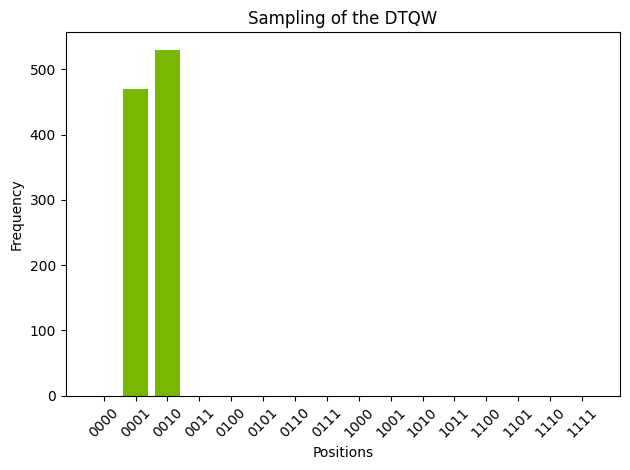

In [17]:
# The DTQW which disallows stepping directly between
# |0000> and |1111>

# Set the number of qubits
num_qubits = 4

@cudaq.kernel
def DTQW_one_step_not_modular(num_qubits: int):
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qubit()
    endpoint_qubit = cudaq.qubit()

    # Initial walker state 1/(sqrt{2}) ( |2>+|3>)
    initial_position(walker_qubits)

    # Initial coin state #CHANGE_ME
    h(coin_qubit)

    # One quantum walk step
    # Coin operation # CHANGE_ME
    h(coin_qubit)

    # Walker's position change

    ## Shifting right

    # (Optional) Avoid shifting from |1111> to |0000> in case the coin is |1> by flipping the coin to |0>
    no_INC_at_right_endpoint(walker_qubits, coin_qubit, endpoint_qubit)

    # Shift right when the coin is |1> and the walker is not in the |1111> state
    INC.ctrl(coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3])

    # (Optional) Reset the coin and endpoints in case they were changed to avoid moving from |1111> to |0000>
    reset_coin_and_endpoint(coin_qubit, endpoint_qubit)

    ## Shifting left

    # (Optional) Avoid shifting from |0000> to |1111> in case the coin is |0> by flipping the coin to |1>
    no_DEC_at_left_endpoint(walker_qubits, coin_qubit, endpoint_qubit)

    # Shift left when the coin is |0>
    x(coin_qubit)
    DEC.ctrl(coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3])
    x(coin_qubit)

    # (Optional) Reset the coin and endpoints in case they were changed to avoid moving from |0000> to |1111>
    reset_coin_and_endpoint(coin_qubit, endpoint_qubit)

    mz(walker_qubits)

# Visualize the kernel for the quantum walk
#print(cudaq.draw(DTQW_one_step_not_modular, num_qubits))

# Sample the kernel for the quantum walk
result = cudaq.sample(DTQW_one_step_not_modular, num_qubits, shots_count=1000)
print(result)
plot_results(result, num_qubits)